# **By Timofei Polivanov, Sami Rahali**

## Lab6-Assignment: Topic Classification

Use the same training, development, and test partitions of the the 20 newsgroups text dataset as in Lab6.4-Topic-classification-BERT.ipynb

* Fine-tune and examine the performance of another transformer-based pretrained language models, e.g., RoBERTa, XLNet

* Compare the performance of this model to the results achieved in Lab6.4-Topic-classification-BERT.ipynb and to a conventional machine learning approach (e.g., SVM, Naive Bayes) using bag-of-words or other engineered features of your choice.
Describe the differences in performance in terms of Precision, Recall, and F1-score evaluation metrics.

# Results from the 6.4 notebook (bert):

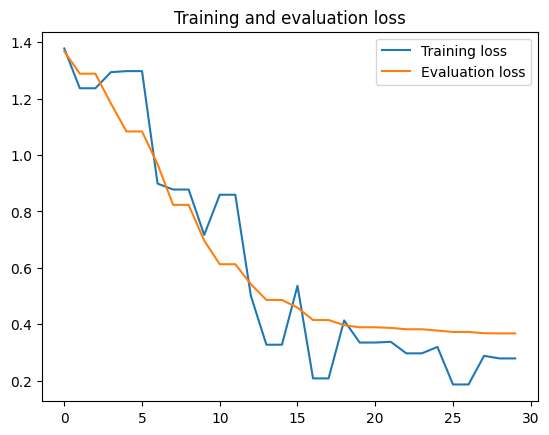

```
              precision    recall  f1-score   support

           0       0.83      0.79      0.81       319
           1       0.92      0.89      0.90       389
           2       0.83      0.91      0.87       396
           3       0.85      0.82      0.84       394

    accuracy                           0.86      1498
   macro avg       0.86      0.85      0.85      1498
weighted avg       0.86      0.86      0.86      1498
```


# Training RoBERTa

In [ ]:
!pip install simpletransformers

In [3]:
# Import libraries
import pandas as pd
import numpy as np
import sklearn
from sklearn.metrics import classification_report
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import matplotlib.pyplot as plt
import seaborn as sn

In [4]:
from sklearn.datasets import fetch_20newsgroups

# load only a sub-selection of the categories (4 in our case)
categories = ['alt.atheism', 'comp.graphics', 'sci.med', 'sci.space']

# remove the headers, footers and quotes (to avoid overfitting)
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'), categories=categories, random_state=42)
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'), categories=categories, random_state=42)

In [5]:
from collections import Counter
Counter(newsgroups_train.target)

Counter({np.int64(3): 593,
         np.int64(1): 584,
         np.int64(2): 594,
         np.int64(0): 480})

In [6]:
Counter(newsgroups_test.target)

Counter({np.int64(1): 389,
         np.int64(2): 396,
         np.int64(0): 319,
         np.int64(3): 394})

In [7]:
train = pd.DataFrame({'text': newsgroups_train.data, 'labels': newsgroups_train.target})

In [8]:
print(len(train))
train.head(5)

2251


text  labels
0  WHile we are on the subject of the shuttle sof...       3
1  There is a program called Graphic Workshop you...       1
2                                                          2
3  My girlfriend is in pain from kidney stones. S...       2
4  I think that's the correct spelling..\n\tI am ...       2

In [9]:
test = pd.DataFrame({'text': newsgroups_test.data, 'labels': newsgroups_test.target})

In [10]:
print(len(test))
test.head(5)

1498


text  labels
0  \nAnd guess who's here in your place.\n\nPleas...       1
1  Does anyone know if any of Currier and Ives et...       1
2  =FLAME ON\n=\n=Reading through the posts about...       2
3  \nBut in this case I said I hoped that BCCI wa...       0
4  \nIn the kind I have made I used a Lite sour c...       2

In [11]:
from sklearn.model_selection import train_test_split

train, dev = train_test_split(train, test_size=0.1, random_state=0,
                               stratify=train[['labels']])

In [12]:
print(len(train))
print("train:", train[['labels']].value_counts(sort=False))
train.head(3)

2025
train: labels
0         432
1         525
2         534
3         534
Name: count, dtype: int64


text  labels
559   I wonder how many atheists out there care to s...       0
2060  We are interested in purchasing a grayscale pr...       1
1206  Dear Binary Newsers,\n\nI am looking for Quick...       1

In [13]:
print(len(dev))
print("dev:", dev[['labels']].value_counts(sort=False))
dev.head(3)

226
dev: labels
0         48
1         59
2         60
3         59
Name: count, dtype: int64


text  labels
1570  I'd dump him.  Rude is rude and it seems he en...       2
1761  Hi Everyone ::\n\nI am  looking for  some soft...       1
455   A friend of mine has been diagnosed with Psori...       2

In [ ]:
# Model configuration # https://simpletransformers.ai/docs/usage/#configuring-a-simple-transformers-model
model_args = ClassificationArgs()

model_args.overwrite_output_dir=True # overwrite existing saved models in the same directory
model_args.evaluate_during_training=True # to perform evaluation while training the model
# (eval data should be passed to the training method)

model_args.num_train_epochs=10 # number of epochs
model_args.train_batch_size=32 # batch size
model_args.learning_rate=4e-6 # learning rate
model_args.max_seq_length=256 # maximum sequence length
# Note! Increasing max_seq_len may provide better performance, but training time will increase.
# For educational purposes, we set max_seq_len to 256.

# Early stopping to combat overfitting: https://simpletransformers.ai/docs/tips-and-tricks/#using-early-stopping
model_args.use_early_stopping=True
model_args.early_stopping_delta=0.01 # "The improvement over best_eval_loss necessary to count as a better checkpoint"
model_args.early_stopping_metric='eval_loss'
model_args.early_stopping_metric_minimize=True
model_args.early_stopping_patience=2
model_args.evaluate_during_training_steps=32 # how often you want to run validation in terms of training steps (or batches)

In [16]:
# Checking steps per epoch
steps_per_epoch = int(np.ceil(len(train) / float(model_args.train_batch_size)))
print('Each epoch will have {:,} steps.'.format(steps_per_epoch)) # 64 steps = validating 2 times per epoch

Each epoch will have 64 steps.


In [17]:
model = ClassificationModel('roberta', 'roberta-base', num_labels=4, args=model_args, use_cuda=True) # CUDA is enabled
print(str(model.args).replace(',', '\n')) # model args

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

ClassificationArgs(adafactor_beta1=None
 adafactor_clip_threshold=1.0
 adafactor_decay_rate=-0.8
 adafactor_eps=(1e-30
 0.001)
 adafactor_relative_step=True
 adafactor_scale_parameter=True
 adafactor_warmup_init=True
 adam_betas=(0.9
 0.999)
 adam_epsilon=1e-08
 best_model_dir='outputs/best_model'
 cache_dir='cache_dir/'
 config={}
 cosine_schedule_num_cycles=0.5
 custom_layer_parameters=[]
 custom_parameter_groups=[]
 dataloader_num_workers=0
 do_lower_case=False
 dynamic_quantize=False
 early_stopping_consider_epochs=False
 early_stopping_delta=0.01
 early_stopping_metric='eval_loss'
 early_stopping_metric_minimize=True
 early_stopping_patience=2
 encoding=None
 eval_batch_size=100
 evaluate_during_training=True
 evaluate_during_training_silent=True
 evaluate_during_training_steps=32
 evaluate_during_training_verbose=False
 evaluate_each_epoch=True
 fp16=True
 gradient_accumulation_steps=1
 learning_rate=4e-06
 local_rank=-1
 logging_steps=50
 loss_type=None
 loss_args={}
 manual_see

In [18]:
_, history = model.train_model(train, eval_df=dev)

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:882: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Running Epoch 1 of 10:   0%|          | 0/64 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 2 of 10:   0%|          | 0/64 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 3 of 10:   0%|          | 0/64 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 4 of 10:   0%|          | 0/64 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 5 of 10:   0%|          | 0/64 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 6 of 10:   0%|          | 0/64 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 7 of 10:   0%|          | 0/64 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


In [19]:
# Training and evaluation loss
train_loss = history['train_loss']
eval_loss = history['eval_loss']
plt.plot(train_loss, label='Training loss')
plt.plot(eval_loss, label='Evaluation loss')
plt.title('Training and evaluation loss')
plt.legend()

In [20]:
# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(dev)
result

0it [00:00, ?it/s]

Running Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


{'mcc': np.float64(0.8470732092019573), 'eval_loss': 0.26889950037002563}

In [21]:
predicted, probabilities = model.predict(test.text.to_list())
test['predicted'] = predicted

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


In [22]:
test.head(5)

text  labels  predicted
0  \nAnd guess who's here in your place.\n\nPleas...       1          1
1  Does anyone know if any of Currier and Ives et...       1          1
2  =FLAME ON\n=\n=Reading through the posts about...       2          0
3  \nBut in this case I said I hoped that BCCI wa...       0          0
4  \nIn the kind I have made I used a Lite sour c...       2          2

In [23]:
# Result (note: your result can be different due to randomness in operations)
print(classification_report(test['labels'], test['predicted']))

              precision    recall  f1-score   support

           0       0.82      0.81      0.82       319
           1       0.90      0.90      0.90       389
           2       0.86      0.91      0.88       396
           3       0.85      0.80      0.83       394

    accuracy                           0.86      1498
   macro avg       0.86      0.86      0.86      1498
weighted avg       0.86      0.86      0.86      1498



# Training SVM

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

# Extract features using TF-IDF
tfidf = TfidfVectorizer(stop_words='english')
X_train = tfidf.fit_transform(train['text'])
X_dev = tfidf.transform(dev['text'])
X_test = tfidf.transform(test['text'])

# Train a Linear SVM model
svm_model = LinearSVC(random_state=42)
svm_model.fit(X_train, train['labels'])

# Evaluate the SVM model on the test set
svm_test_predictions = svm_model.predict(X_test)
print(classification_report(test['labels'], svm_test_predictions))

              precision    recall  f1-score   support

           0       0.84      0.77      0.80       319
           1       0.88      0.89      0.88       389
           2       0.88      0.83      0.86       396
           3       0.78      0.87      0.82       394

    accuracy                           0.84      1498
   macro avg       0.85      0.84      0.84      1498
weighted avg       0.85      0.84      0.84      1498



# Comparing results

BERT:
```
              precision    recall  f1-score   support

           0       0.83      0.79      0.81       319
           1       0.92      0.89      0.90       389
           2       0.83      0.91      0.87       396
           3       0.85      0.82      0.84       394

    accuracy                           0.86      1498
   macro avg       0.86      0.85      0.85      1498
weighted avg       0.86      0.86      0.86      1498
```

RoBERTa:
```
              precision    recall  f1-score   support

           0       0.82      0.81      0.82       319
           1       0.90      0.90      0.90       389
           2       0.86      0.91      0.88       396
           3       0.85      0.80      0.83       394

    accuracy                           0.86      1498
   macro avg       0.86      0.86      0.86      1498
weighted avg       0.86      0.86      0.86      1498
```

SVM:
```
              precision    recall  f1-score   support

           0       0.84      0.77      0.80       319
           1       0.88      0.89      0.88       389
           2       0.88      0.83      0.86       396
           3       0.78      0.87      0.82       394

    accuracy                           0.84      1498
   macro avg       0.85      0.84      0.84      1498
weighted avg       0.85      0.84      0.84      1498
```




#### Precision
SVM slightly outperformed BERT and ROBERTA for class 2, otherwise, it performed slightly worse. ROBERTA performed slighlty better than BERT for class 2, otherwise it had either the same, or slightly worse performance. For the average precision, BERT and ROBERTA had the same score, while SVM's score was slightly lower.

#### Recall
Overall ROBERTA performed slightly better than BERT, with the exception of class 3. SVM performed considerably worse than both, with the exception of class 3 too, here it performed better than both. For the average recall, ROBERTA performed the best, while SVM performed the worst.

#### f1-score
Similarly, overall ROBERTA performed slightly better than BERT, with the exception of class 3. SVM performed worse than both models across the board. For the average f1-score, ROBERTA placed first, and SVM placed third, same as before.

#### Conclusion
Overall, the models performed very similarly, with slight variance. For the most part RoBERTa performed the best, however, SVM, being a way simpler model, was still very competitive and showed almost as great of a result.

In my opinion, taking the very long training time and complexity of the transformer models, I count this as a win for SVM, because it fit the dataset in seconds, and the performance drop was negligible.

In [ ]:
#(/,,,,,**/*,,,,,,,***/#(,..,/##/*,   .,**/((###(//(##(####(((((//*/////////////**,****,,,,,****,     .***,**//*,,**//(#%%%##(((*,,**/(//***(##((#%%%%#(#%#(((((////((#%&&&&&&&&&&&&&&&&&&&%##%%&&%&&&&&
%#/,,,,***/*,,,,,,,***/(/,..*((/*,.      .,*//*//((########(((((/////////////**,.  ,****,,,*****,.     .*****///*,,,***/(#%%#(*,,*,****///**/##((#%%%%#((%%#/***//**/(((#&@@&&%%&&%%%&&&&&&%##%&&&&%&&&&
%(*,,,,**/*,,,,,,,,**/((*...*((*,.          .,*///**/(#######(((///*/////**,..     .,,***,,,**/*,.      ,**,**/(/,,,,,****/((//****,***,*//**/##((#%%%%#((((/**/////**/((#%@@&%#%%%%%%%&&&&#(#%&&&&%&&&&
#/,,,,***/*,,,,,,,,*//((*..,*//,.              .,*////(#####%#####((///*,.          .****,.,**/*,.       .**,,*//*,.,,,,**,,,*/////*******/***(#((##%%%%#(/****///////*//(#%&&#((#%%%%%%&%###%&&&&&&&&&&
#/,,,*****,,,,,,,,,*//(/*..*//*.                  .,*//(####((((###((/**,,,,,,,.... .,,***,,,*//*.        .**,,*//*,.,,,,,,,,..,*////***,**/**(##(###%%##(*,,,,*////////***(#&%(((#%%%%%%(/(#%&&&&&&&&&&
#*,,,*****.,**,,,,,*//((*..*//,                      .,*(#%###(///*,..,,******,,,*//*,,****,,,***,.        .**,,,//,.,,,,,..,,,...*/(//**,**/*/#######%##/*,.  ,**///**,,...*#%#((##%%%%(**/#%&&&&&&&&&&
(,,,*****,.,,,,,,,*////(*..*/*.             ........    .*#%%#(//*,..   .....,,,,,.    ,****,,***,.         .,*,.,//*..,,.....,....,*/((/,,***/(########(/**,.....,**,.     .*###((#%%%#/*/(#%%&&&&&&&&&
/,,,***/*,..,,,,,,*/////*..**,.         ...,,,,,...........*(#(,..,**,.     ....        ,****,,**,.           ,*,.,*/,,.,,,,,,.....,,**//(/***//########(//*,,,,,...         .*(##((#%(//(#####%&&&&&&&&
*,,****/*..,,,,,,,*/////*,.**,. ..,**//#%%#########((//**,...*((*...,,,.                 ,**//****,.           .**,,**,,..,*(/,..,..,/((/*,*//*/(########%%%##(####%%#//**,.  ,/##((((/#%%##((#%%&&&&&&&
*,,***//,...,,,****//*///,./%%%%%##%%&&%%######(((((((((####(//(#(*,..,..                 .**/((/*,..            ,*,,*/*,..,/(/,.,**,,/(((**/#####%%%########(#####%%%%&%%##%%%%%#((((%&%%#(((#%%%%&&&&&
*,****//,..,,,*****//*///,,/%&&%###%%#######%%&&&&%%%%%######%%%###(*,.....                 ,*/(((*,.             .**,*//,..*(#(/,*/***(#%###%&%%%%%%%&&&&&&&&%%########%####%&@&%(((#%%%#(//(#%%%%%&&&&
*,****/*,..,*,***,*/**(%#,./#%##%&&&#%&@&%%%&&%%%%#(#%&&@@@&&%%%%&%%%%%(/,,,,..              .*/((*,..              .,**/(*,,//***/(##%%%&&@&&&&&@@@@&%##%%%%%%&&%%&@&%#%&&&%##%%%#((#%%#///((#%%%%%%&&&
,,***//*...*****,*//**#@%*.*#&&%(*.,/(/,  ,(#(//**/##(**,,*/((%&%##%&&%%(//*.  .....           ,*/(/*,.               .,*/((***/**//(%&&&%##%%#(/**,**/(#(/*///##/. .*/(*.,*#&&%%%#((##(////(##%%%%%%&&&
,,***//*...*/*/*,*//*(&@&(,*/*    ..     ,(#(/**/(#/*,**,,,,,,,*(#/*/#%&@#*                     .,*,,***,,.....          ,*////(/*(%&&#(**(#(*,*,,,****,*(#/***/##/.     ..    *#&%(##(/////(#%%%%%%%&&&
,,***/*,..,*///*,*/*/(%&@%/*/*.   ....   ,((/*,*/(*,,,,***,,**,,,*/**/(/,/#(,                     .**,........              .*,,/#(*,//**//*,,***,,**,,,,,///,,*(#(.  ...     ,/%%%##(//////(#%%%%%%&&&&
,,**//*,..,*///*,*//(##((((/((*.         ,/(/,,*/*,,,,,/#%%%%#*.,,****((,  ,,.                      .**,                       .,. .*(/**/*,,,/#%%%%(,,,,,*//*,*(#/.         ,(#%&%#(//////((#%%%%%&&&&%
*,**//*,...*///*,*//(/,. ./((##/.        .*(/,,*/*,....,/(//(/,..,****/(,                              ,**.                        ./(*,*/*...*(///(/,...,*//,,*((*.        ,(%#/(#(///////(##%%%&&&&&&%
****//*,...*/(/,,*/(//,. .*((#%#/.        ,//*,,*/,.....,/%%#*...,**,*(/,                                 ..                       .*(/,,*,...,/%%#*,.....*/*,,/(*.        ,(#/../(///////((#%%&&&&&&&&%
****//*,...*/(/,,/((/*,.  ,/((//(/,        *//*..*/*............,**,,/(/.                                                           ,/(*,,*,............,*/*,,/(/,       .*(/. ,/(////////(##%&&&&&&&&%%
*****/*,...*((/,*/(#(*,   .,*(#(/(/*       .......,**,.........***,.,**,                                                            .,/*,.,**,........,**,..,,...       ./(/,.,/(/////////(#%&&&&&&&&%%%
**/****,...*((/,*/(#%(,   .,,*/(/. ..         ,**,.  .,,,,,,,,,. .*/*,                                                                .,//,. .,,,,,,,,,.  ,**,.         ..  .*((/////////(##&&&&&&&%%%%%
*//****,.. ,(#/**//*(#(,   .,*,*//,  .*//*,.   ,/((/,.        .,/(#(,.                                                                 .*(#(*.         .*(((*.   .,*(/,    ,/(///////////(#&&&%%%&%%%%%%
//*****,.. ,/#(**//***(#*  ..,*,.,*,..***,,..  ....,*/((/***////*.                                   ...                                  .,*///****/((/*....   ..,,,*,. .*/(///////////(#&&%%%&&%####%%
//*****,.. .*#(////**../#/. ..,*,....................,*,.   .,,..                                 .........                           .......,,..   .,,,............    ,/((///////////(%&&%%%%%######%%
/******,,. .*((((/**//*.*(/, ..,,,............................                                    .........                        .................................. .*((/////////((/(%&&%%%#######%%%%
********,.. ,(##(/****//**(/,  ..,,..............................                                  .......                      ................................... .*((////////(((//(%&&%%###(((##%%%%%
********,,. ./##(****,,*//*//,....................................                                   ..                         ...................................,/(////////(##/*/%@&%###(((((#%&&%%%%
*********,. .,(##(/*.....  ,//,.................................                                     ...                            .............................,/((//////(#%#/*/#&%###(((((((%&&%%%%%%
**********,. ./#(/((*.  .,,*(#(,..............................                                                                              ...................,/((/////(#%#(//(%&#(###((((((%&%%%%%%%%%
**********/, .,(#(/*/(/,.,/(//(/,. .........................                                                                                 ...............,*((////((#%%#((#%%%####(((((((#%%%%%%%%%%%%
************. ./(#(/////////**/((,. .......................                                                                                     ........ .*/((///(##%%##(((#%%%##((((((((#%%%%%%%%%%####
************,..,/#(///(/*///(###((*.     . .............                                                                                              .,/((//(#%%%%#((/***(#%%##(((((((%%%###########%%&
*************,..*/##//((/***/##(/(#/.                                                                                                              .,/((/(###(/*,,*****,/#%####(((//(#%#############%%&%
**************..,*((#(/((/*//(#%#((#(,                                                                                                         .,/(######/,   .******,*(%#((##(((((%%#########%%%%%%&%%%
*/*********,*/*,.*//(##((/**/((#%%%%%#/.                                                                                              .,,,,*/#%%##(/*,.   .,********,*#&#/(##((((#%#########%&%%%%%%%%%%
*//********,*(#/.,/(//(#%(/*/(((#%%%%&%#*                                        ,*/*,,..                          ...,,*/*.            ......        ..,******,,...*#%%#((#(((#%########%&&&%%%%%%%%%%%
,//********,*#&%/.,(#/*/(##(((/(#%%%%%%%%#*.                                        ...,,,*****,,....  .....,******,,....                   ......,,*****,,,..   .*#%%%%###((#########%%&&%%%%%%%%%%%%%%
,***,******,*(%&%/,,#%/*/((((##(#%%%%%%%%%%#/.                                                                                                 .......         ./%&%%%%&%#((####%%###&&%%%%%%%%%%%%%%%%%
.***,,*******#%%%%(*,(%//((/((/*(%%%%%%%%%%%&%(,                                                                                                             *#%&%%%%%%&%##########&&%%%%%%%%%%%%%%%%%%%
.,**,,******/#%%%%%%/,/##(/((/**(%%%%%%%%%%%%%%&%/,                                                                                                       ,(%&%%%%%%%%%%%#######%&&%%%%%%%%%%%%%%%%%%%%%
..**,,,*****/#%%%%%%%#**(#(((/**(#%%%%%%%%%%%%%%%%&%(*.                                                                                               .*(%%%%%%%%%%%%%%&%#(####%&%%%%%%%%%%%%%%%%%%%%%%%
..*/*,.,*****#%%%%%%%%%#//#(/***/#%%%%%%%%%%%%%%%#%%%%%#/,.                                                                                       .*(#%%%%%%%%%%%%%%%%&%#((##%%%%%%%%%%%%%%%%%%%%%%%%%%%
,.,//,.,****/#&%%%%%%%%####((/**/#%%%%%%%%%%%&&&&&&&&&&%%%%#/,                                                                                .*(#%&&&&&&&%&&&&%%%%#%&&#((##%%%%%%%%%%%%%%%%%%%%%%%%%%%%
*,,,**..,**,*(%%%%%%%###%%%%##(//#%%%%%%%&&&&%%%%%%%%%&&&&&&&@&%/,.                                                                       .*(&@&&&&&&%%%%%%%%%%%&&&&%&%(/(#%&&%%%%%%%%%%%%%%%%%%%%%%%%%%
*,,,//,..,***(%%%%%##%%%%%%%(/*/(###%%%&&%%%%%%%%%%%%%%%%%%%%%%%&&&%#*.                                                              .,/%&&&&%%%%%%%%%%%%%&&%%%%%%%&&@%(/(#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%